In [410]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn; seaborn.set()
from sortedKmeans import *

# VIX prediction
- Unsupervised learning to label VIX monthly returns
    - Example:
    - -10%-0% -- small fall (label 1)
    - 0%-10% -- small rise (label 2)
    - geater than 30% -- big strike (label 3)
- Supervised learning to predict the labels
    - Given the Macro input, whats the label of return next month
    - Smll rise?
    - Big spike?
    - ...

## 1. Data Cleaning
- excel shit to dataframe 
- try to make features stationary

In [411]:
monthly = pd.read_excel('macro_data.xlsx',sheet_name = 0)
daily = pd.read_excel('macro_data.xlsx',sheet_name = 1)

In [412]:
def clean(monthly):
    
    data = monthly.loc[6:, monthly.columns[1::3]]
    col = monthly.iloc[2,::3].tolist()
    date = pd.to_datetime(monthly.iloc[6:,0])
    data.columns = col
    data.index = date
    data.index.name = 'Date'
    
    return data

In [413]:
dataM = clean(monthly)
dataD = clean(daily)

dataM = dataM.merge(dataD[['VIX']], left_index = True, right_index = True).drop(columns = ['EuroDebtToGDP'])

dataM['VIX1mret'] = dataM['VIX'].shift(-1)/dataM['VIX']-1
dataM['VIX1mret_lagged'] = dataM['VIX']/dataM['VIX'].shift(1)-1
#dataM = dataM.drop(columns = ['VIX'])

# Make feartures stationary, trun abosulute values to growths
dataM['PrivateHouseStartedGrowth'] = dataM['PrivateHouseStarted']/dataM['PrivateHouseStarted'].shift(1) - 1
dataM['PrivateDebtOutstandingGrowth'] = dataM['PrivateDebtOutstandingTotal']/dataM['PrivateDebtOutstandingTotal'].shift(3) - 1
dataM['PrivateBorrowTotalGrowth'] = dataM['PrivateBorrowTotal']/dataM['PrivateBorrowTotal'].shift(3) - 1

dataM = dataM.drop(columns = ['PrivateDebtOutstandingTotal','PrivateBorrowTotal','PrivateHouseStarted'])

dataD['VIX1dret'] = dataD['VIX'].shift(-1)/dataD['VIX']-1
dataD['VIX1dret_lagged'] = dataD['VIX']/dataD['VIX'].shift(1)-1
#dataD = dataD.drop(columns = ['VIX'])
#dataD['VIX1dret'].map(float).hist(bins=20)

- Simply plot the VIX

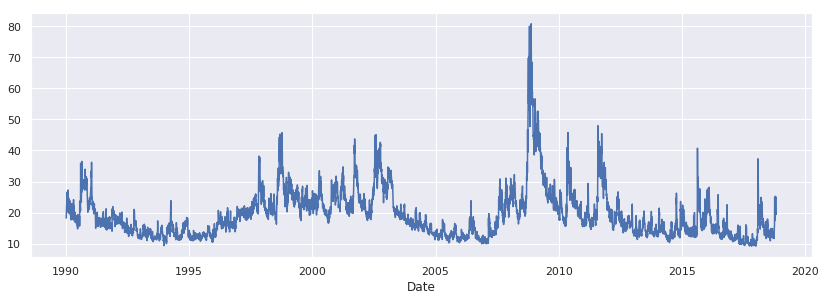

In [414]:
# Simply plot VIX
dataD['VIX'].plot(figsize = (14,4.5))

- Data Header

In [415]:
dataM.head()

,GDPQ,ConsumptionQ,GovtSpendingQ,InvestmentQ,CPI_Y,FedDebtToGDP,Unemployment,PPI_Y,CPI_Urban_M,ConsumptionM,PrivateDebtGrowth,SurplusToGDP,VIX,VIX1mret,VIX1mret_lagged,PrivateHouseStartedGrowth,PrivateDebtOutstandingGrowth,PrivateBorrowTotalGrowth
Date,,,,,,,,,,,,,,,,,,
1990-03-30,4.4,3.4,6.6,4,5.23,51.969,5.3,4.5,0.5,0.7,7.8,-3,19.73,-0.0106437,NaN,NaN,NaN,NaN
1990-04-30,4.4,3.4,6.6,4,5.23,52.747,5.3,3.7,0.2,0.4,7.8,-2.9,19.52,-0.110143,-0.0106437,-0.0318076,NaN,NaN
1990-05-31,4.4,3.4,6.6,4,5.23,52.747,5.3,3.1,0.2,0.2,7.8,-3.2,17.37,-0.107657,-0.110143,-0.0288462,NaN,NaN
1990-06-29,1.5,1.2,0.6,0.1,4.6,52.747,5.33,3.1,0.6,0.8,6.4,-3.5,15.5,0.361935,-0.107657,-0.0288779,0.0157609,-0.16746
1990-07-31,1.5,1.2,0.6,0.1,4.6,53.753,5.33,3.6,0.5,0.5,6.4,-3.6,21.11,0.41639,0.361935,-0.00509771,0.0157609,-0.16746


- Features selected

In [416]:
print(dataM.columns.values)

['GDPQ' 'ConsumptionQ' 'GovtSpendingQ' 'InvestmentQ' 'CPI_Y'
 'FedDebtToGDP' 'Unemployment' 'PPI_Y' 'CPI_Urban_M' 'ConsumptionM'
 'PrivateDebtGrowth' 'SurplusToGDP' 'VIX' 'VIX1mret' 'VIX1mret_lagged'
 'PrivateHouseStartedGrowth' 'PrivateDebtOutstandingGrowth'
 'PrivateBorrowTotalGrowth']


## 2. Kmeans Clustering of VIX returns 
- unsupervised learning
- breakdown train data into 4 clusters such that the variances with each clusters are the same
    - i.e. Var(cluster1) = Var(cluster2)

### 2.1 Fit kmeans for train set, apply the fitted kmeans to test set
- Train set 1990 - 2010
    - Fit a model that cluster VIX monthly return by boundries listed below
    - level 1: < -0.0679
    - level 2: -0.0679 ~ 0.109
    - level 3: 0.109 ~ 0.349
    - level 4: > 0.349
- Test set 2010 - 2018
    - Label Vix return in test using the scheme above

In [417]:
from sklearn.cluster import KMeans 
import pandas as pd
import numpy as np

class kmeans_1d:
    
    def __init__(self, x, n = 5, binary = True):
        self.x = x
        self.date = x.index
        self.n_clusters = n
        self.kmeans = self.fit()
        self.binary = binary
        self.label = self.mapping()
    
    def fit(self):
        date = self.date
        if self.x.ndim !=2:
            self.x = np.array(self.x).reshape(-1,1)
        kmeans = KMeans(n_clusters = self.n_clusters).fit(self.x)
        return kmeans
    
    def mapping(self):
        kmeans = self.kmeans

        # map raw_label to sorted label
        label = pd.DataFrame({'center':kmeans.cluster_centers_[:,0],
                        'raw_label':kmeans.predict(kmeans.cluster_centers_[:,0].reshape(-1,1))})
        label = label.sort_values(by ='center')
        if self.binary:
            binary = np.zeros(self.n_clusters)
            binary[-1] = 1
            label['label'] = binary
        else:
            
            label['label'] = range(1, self.n_clusters+1)
            #np.sort( kmeans.cluster_centers_[:,0]) # label with centers
        
        return label
    
    def predict(self, to_predict):
        kmeans = self.kmeans
        label = self.label
        date = to_predict.index
        
        if to_predict.ndim != 2:
            to_predict = np.array(to_predict).reshape(-1,1)        
        
        
        def label_transform(l):
            return label[label.raw_label==l]['label'].iloc[0]

        return pd.Series(np.vectorize(label_transform)(kmeans.predict(to_predict)),index = date)
    
    def train(self):
        # turn VIX return into VIX label in train set
        
        # map return to raw_label
        a = pd.DataFrame({'raw_label':self.kmeans.labels_,
                      '1fwdret': self.x[:,0]})
        
        return a.merge(self.label,on = 'raw_label',how = 'left').set_index(self.date).drop(columns = 'raw_label')
    

In [418]:
split = 12*25
n_clusters = 4

y_train_ret = dataM[3:split]['VIX1mret']
fitted = kmeans_1d(y_train_ret, n_clusters, binary = False)
y_train = fitted.train()['label']

X_train = dataM[3:split].drop(columns = 'VIX1mret')

y_test_ret = dataM[split:-1]['VIX1mret']
y_test = fitted.predict(y_test_ret)
X_test = dataM[split:-1].drop(columns = 'VIX1mret')

center = np.sort(fitted.kmeans.cluster_centers_, axis = 0)
boundry = (center[1:] + center[:-1])/2
print('boundry of clusters:', boundry.flatten())

boundry of clusters: [-0.1117787   0.05718655  0.29698078]


### Train set VIX return histogram
- dark blue = level 1 (small fall)
- red = level 4 (big spike)

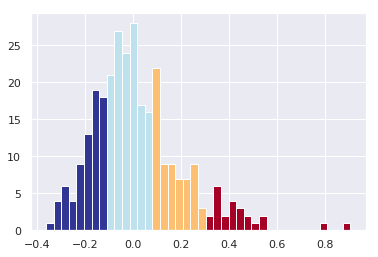

In [419]:
def labeled_hist(y, bins = 40):
    cm = plt.cm.get_cmap('RdYlBu_r')

    n, bins, patches = plt.hist(y, bins = bins)

    for c, p in zip(bins[:-1], patches):
        c = (c > boundry).sum()/3
        plt.setp(p, 'facecolor', cm(c))

labeled_hist(y_train_ret.astype(float))

### Test set return histogram

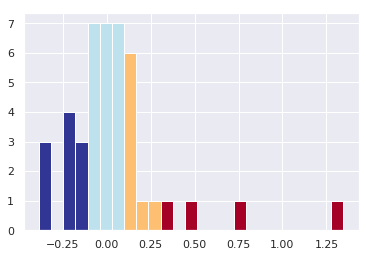

In [420]:
labeled_hist(y_test_ret.astype(float), bins = 25)

## 3. Logistic regression to predict labeled VIX return
- supervised learning
- predict the probobility of labels of VIX return in next month
    - Example:
    - Probability of next month return higher than 35% (level 4) is 0.03

### 3.1 Cross Validation for the penaty parameter in Logistic Regression
- c=0.11 gives the best cross validation accuracy

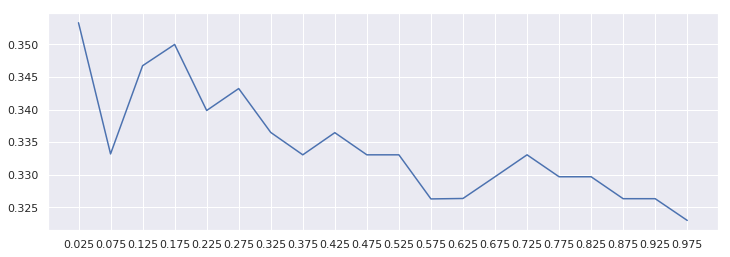

In [421]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_ = pd.DataFrame(scaler.transform(X_train),columns = X_train.columns, index = X_train.index)
X_test_ = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns, index = X_test.index)

cv_mse = []
pen_list = np.arange(0.025,1,.05)
for pen in pen_list:
    clf = LogisticRegression(random_state=0, C=pen,class_weight= None, multi_class = 'multinomial',solver='lbfgs')
    cv_mse.append(np.mean(cross_val_score(clf, X_train_, y_train, cv=3, scoring = 'accuracy')))

fig = plt.figure(figsize=(12,4))
plt.plot(pen_list,cv_mse)
plt.xticks(pen_list);

### 3.2 Using c = 0.175 in our final prediction model
- In sample fit
- Accuracy: percentage of correct bet
    - Example:
    - Actual next month VIX ret is 40% > 35%, should be labeled as level 4
    - Model prediction: Prob of level 4 is 50%, higher than prob of any other labels, model predicts next month return as label 4
    - Correct bet!

In [422]:
clf = LogisticRegression(random_state=0, C=.175,class_weight = None, multi_class = 'multinomial',solver='lbfgs').fit(X_train_, y_train)
print('In Sample Accuracy:',clf.score(X_train_, y_train))

In Sample Accuracy: 0.42424242424242425


### Out sample fit
- This model learns a lot from the 08 crisis, before the crisis the economica data is overheated
- Nowadays, economic indicator is pretty hot too 
- So in the past 2 years, the model always predict the level 4 (Big spike)

- Genrally, this model overestimate the VIX, because there might be some other factor driving a spike

Out Sample Accuracy: 0.46511627906976744


array([[1.        , 0.07413641],
       [0.07413641, 1.        ]])

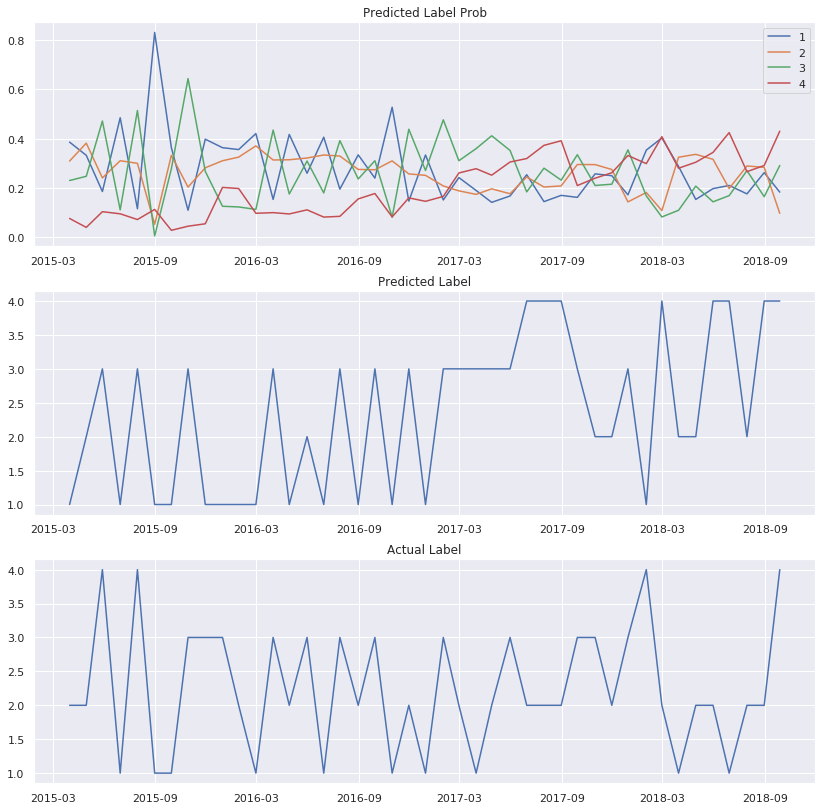

In [423]:
plt.figure(figsize=(14,14))
plt.subplot(3,1,1)
plt.title('Predicted Label Prob')
for i in range(len(clf.classes_)):
    plt.plot(y_test.index,clf.predict_proba(X_test_)[:,i], label = clf.classes_[i])
plt.legend()

plt.subplot(3,1,2)
plt.title('Predicted Label')
plt.plot(y_test.index, clf.predict(X_test_))

plt.subplot(3,1,3)
plt.title('Actual Label')
plt.plot(y_test)

print('Out Sample Accuracy:', clf.score(X_test_,y_test))
#np.corrcoef(y_test_ret.astype(float),clf.predict_proba(X_test_)[:,3])

## 4. Feature Importance of Logistic Regression (OS)
- Drop one fature, See how much worse the model get

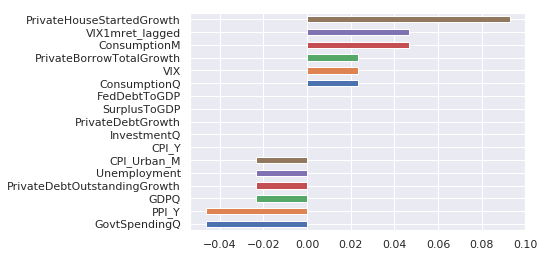

In [424]:
def shuffle_sereis(x):
    return pd.Series(np.array(x.sample(frac=1)),index = x.index)

def MDA(c, X_train, y_train):
    X = X_train.drop(columns = c)
    #X[c] = shuffle_sereis(X_train[c])
    if X.ndim!=2:
        X = np.array(X).reshape(-1,1)
    clf = LogisticRegression(random_state=0, C =.175, class_weight = None, multi_class = 'multinomial',solver='lbfgs').fit(X, y_train)
    
    return clf.score(X_test_.drop(columns = c), y_test)

ImpList=[]
for c in X_train.columns:
    ImpList.append(MDA(c, X_train_, y_train))
    
ImpSeries = pd.Series(clf.score(X_test_,y_test) - np.array(ImpList), index = X_train.columns)
ImpSeries.sort_values().plot.barh();

## Weak predictive power

## Tried 
- ordinal, turn class label to real number, failed
- combined with daily, using its 4th level probability as a feature (BECAUSE ITS POSITIVE COREELATION WITH VIX RETURN), failed
- maybe code a self defined losss function for ordinal logistic regression ! (might takle long time)

In [402]:
# X_train_ = X_train_.drop(columns = ['FedDebtToGDP','SurplusToGDP','VIX1mret_lagged','InvestmentQ'])
X_test_ = X_test_.drop(columns = ['FedDebtToGDP','SurplusToGDP','VIX1mret_lagged','InvestmentQ'])

In [407]:
clf = LogisticRegression(random_state=0, C=.105,class_weight = None, multi_class = 'multinomial',solver='lbfgs').fit(X_train_, y_train)
print('In Sample Accuracy:',clf.score(X_train_, y_train))

In Sample Accuracy: 0.41414141414141414


Out Sample Accuracy: 0.37209302325581395


array([[1.        , 0.11637326],
       [0.11637326, 1.        ]])

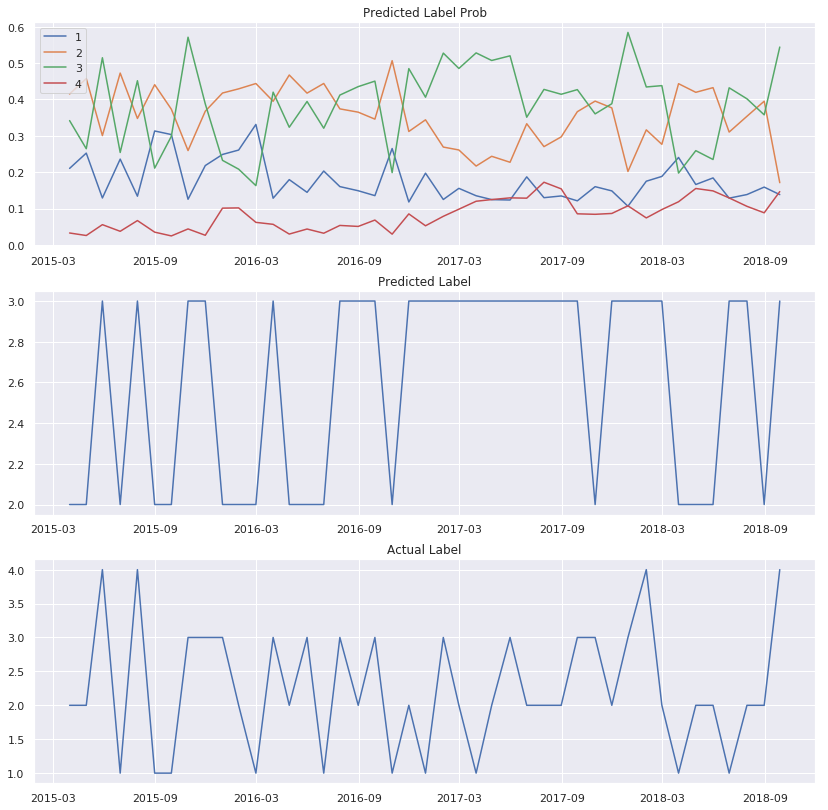

In [408]:
plt.figure(figsize=(14,14))
plt.subplot(3,1,1)
plt.title('Predicted Label Prob')
for i in range(len(clf.classes_)):
    plt.plot(y_test.index,clf.predict_proba(X_test_)[:,i], label = clf.classes_[i])
plt.legend()

plt.subplot(3,1,2)
plt.title('Predicted Label')
plt.plot(y_test.index, clf.predict(X_test_))

plt.subplot(3,1,3)
plt.title('Actual Label')
plt.plot(y_test)

print('Out Sample Accuracy:', clf.score(X_test_,y_test))
np.corrcoef(y_test_ret.astype(float),clf.predict_proba(X_test_)[:,3])

## Conclusion
- weak predictive power
- Consider to use the probobility of level 4 as a feature in daily data fitting

In [250]:
feature_M = pd.Series(clf.predict_proba(X_test_)[:,1], index = y_test.index)

## 5. Daily data

In [294]:
dataD = dataD[dataD.index >= X_test_.index[0]].drop(columns = 'OBFR')

In [254]:
# dataD['featureM'] = feature_M
# dataD['featureM'] = dataD['featureM'].fillna(method = 'ffill')

In [295]:
dataD.head()

,FedRate,JPMorganCreditSpread,SPX,VIX,SX5E,EuroDollar1Comdty,UST2Y,UST10Y Index,UST30Y,UST3M Index,UST5Y,ConsumerDiscretionaryETF,RealEstateETF,DollarSpot(BBD),DollarSpot(DXY),VIX1dret,VIX1dret_lagged
Date,,,,,,,,,,,,,,,,,
2016-04-07,0.37,167.935,2041.91,16.16,2871.57,99.33,0.6878,1.6889,2.5149,0.2289,1.1367,122.12,82.7,1184.91,94.482,-0.049505,0.146913
2016-04-08,0.37,167.284,2047.6,15.36,2911.98,99.315,0.695,1.7167,2.5525,0.2238,1.151,122.02,83.16,1179.2,94.235,0.0585938,-0.049505
2016-04-11,0.37,166.925,2041.99,16.26,2924.23,99.31,0.6987,1.7254,2.5616,0.2136,1.1575,121.62,82.99,1174.15,93.95,-0.0867159,0.0585938
2016-04-12,0.37,165.42,2061.72,14.85,2942.09,99.31,0.7385,1.7761,2.5989,0.2238,1.2109,122.55,83.59,1171.92,93.959,-0.0680135,-0.0867159
2016-04-13,0.37,164.358,2082.42,13.84,3039.19,99.31,0.7464,1.7639,2.5837,0.2238,1.2125,124.45,83.22,1179.16,94.744,-0.00867052,-0.0680135


In [296]:
split = int(len(dataD)*0.7)
n_clusters = 4

y_train_ret = dataD[:split]['VIX1dret']
fitted = kmeans_1d(y_train_ret, n_clusters, binary= False)
y_train = fitted.train()['label']

X_train = dataD[:split].drop(columns = 'VIX1dret')

y_test_ret = dataD[split:-1]['VIX1dret']
y_test = fitted.predict(y_test_ret)
X_test = dataD[split:-1].drop(columns = 'VIX1dret')

center = fitted.kmeans.cluster_centers_
center.sort(axis = 0)
boundry = (center[1:] + center[:-1])/2
print('boundry of clusters:', boundry.flatten())

boundry of clusters: [-0.04372332  0.03954337  0.25296201]


## Try ordinal regression

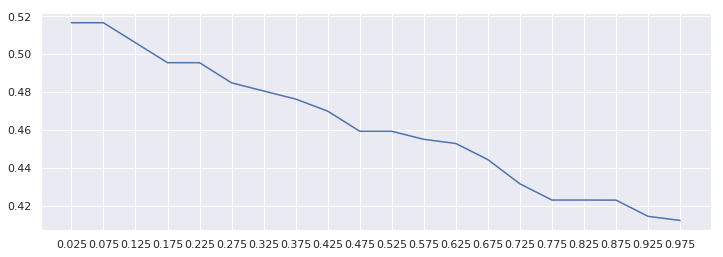

In [297]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_ = pd.DataFrame(scaler.transform(X_train),columns = X_train.columns, index = X_train.index)
X_test_ = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns, index = X_test.index)

cv_mse = []
pen_list = np.arange(0.025,1,.05)
for pen in pen_list:
    clf = LogisticRegression(random_state=0, C=pen, multi_class = 'multinomial',solver='lbfgs')
    cv_mse.append(np.mean(cross_val_score(clf, X_train_, y_train, cv=3, scoring = 'accuracy')))

fig = plt.figure(figsize=(12,4))
plt.plot(pen_list,cv_mse)
plt.xticks(pen_list);

In [298]:
clf = LogisticRegression(random_state=0, C=1,class_weight='balanced', multi_class = 'multinomial',solver='lbfgs').fit(X_train_, y_train)
print('In Sample Accuracy:',clf.score(X_train_, y_train))

In Sample Accuracy: 0.39065817409766457


Out Sample Accuracy: 0.3118811881188119


array([[1.        , 0.22560321],
       [0.22560321, 1.        ]])

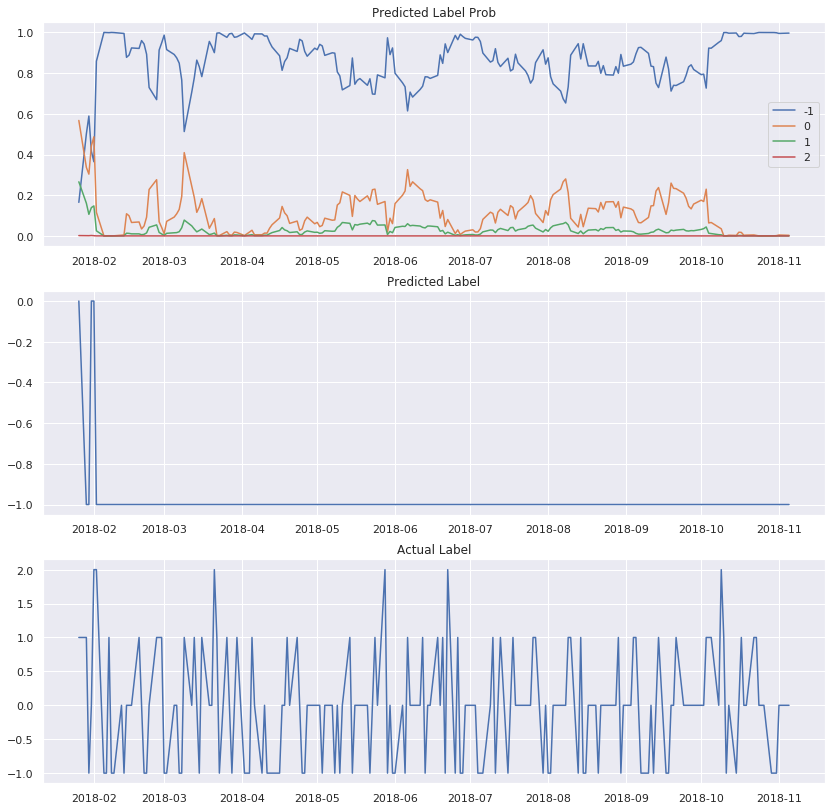

In [299]:
plt.figure(figsize=(14,14))
plt.subplot(3,1,1)
plt.title('Predicted Label Prob')
for i in range(len(clf.classes_)):
    plt.plot(y_test.index,clf.predict_proba(X_test_)[:,i], label = clf.classes_[i])
plt.legend()

plt.subplot(3,1,2)
plt.title('Predicted Label')
plt.plot(y_test.index, clf.predict(X_test_))

plt.subplot(3,1,3)
plt.title('Actual Label')
plt.plot(y_test)

print('Out Sample Accuracy:', clf.score(X_test_,y_test))
np.corrcoef(y_test_ret.astype(float),clf.predict_proba(X_test_)[:,1])

In [292]:
from sklearn.linear_model import Ridge
reg = Ridge(alpha = 0,fit_intercept=False).fit(X_train_, y_train)
reg.score(X_train_, y_train)
pd.Series(reg.coef_, index = X_train_.columns)

FedRate                     0.000435
JPMorganCreditSpread       -0.007181
SPX                         0.354290
VIX                        -0.142126
SX5E                       -0.025041
EuroDollar1Comdty          -0.054123
UST2Y                       0.146967
UST10Y Index                0.127314
UST30Y                      0.031636
UST3M Index                -0.076182
UST5Y                      -0.218090
ConsumerDiscretionaryETF   -0.386991
RealEstateETF              -0.032981
DollarSpot(BBD)             0.183399
DollarSpot(DXY)            -0.155343
VIX1dret_lagged            -0.020340
featureM                    0.051814
dtype: float64

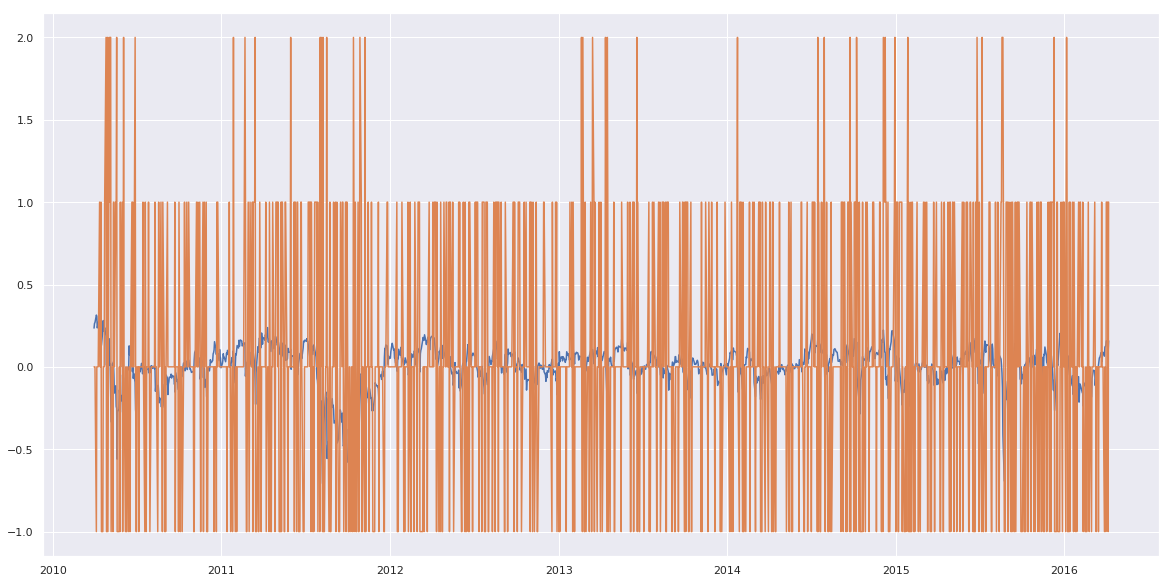

In [286]:
fig = plt.figure(figsize=(20,10))
plt.plot(y_train.index, reg.predict(X_train_)) 
plt.plot(y_train)

In [33]:
np.vectorize(round_to_label)(reg.predict(X_test_))

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [32]:
reg.predict(X_train_) 
def round_to_label(x):
    x = int(x) if ((x%1 > 0) and ((x%1) <= 0.5)) else int(x)+1
    return x

### Below is not for the second draft

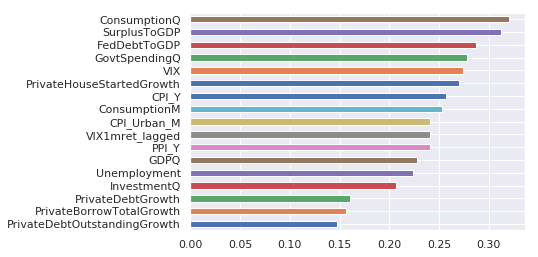

In [257]:
def SingleFeaImp(c, X_train, y_train):
    X = X_train[c]
    if X.ndim!=2:
        X = np.array(X).reshape(-1,1)
    clf = LogisticRegression(random_state=0, class_weight = 'balanced', multi_class = 'multinomial',solver='lbfgs').fit(X, y_train)
    return clf.score(X, y_train)

ImpList=[]
for c in X_train.columns:
    ImpList.append(SingleFeaImp(c, X_train, y_train))
ImpSeries = pd.Series(ImpList, index = X_train.columns)
ImpSeries.sort_values().plot.barh()

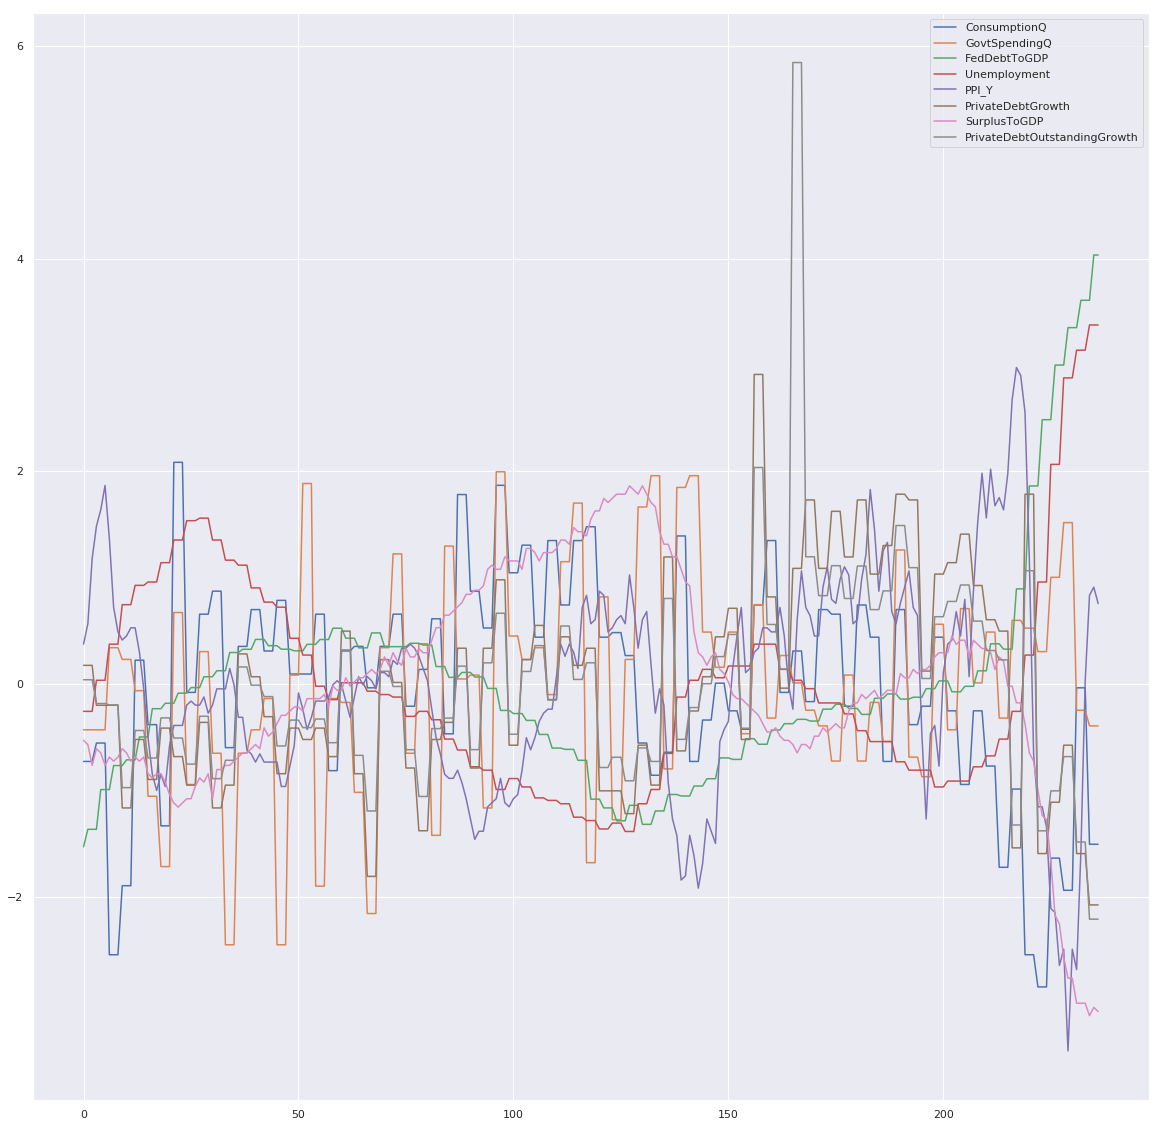

In [146]:
pd.DataFrame(scaler.transform(X_train),columns = X_train.columns)[li].plot(figsize=(20,20));

In [108]:
from statsmodels.tsa.stattools import adfuller
li = []
for c in X_train.columns:
    if adfuller(X_train[c])[1]>0.05:
        li.append(c)

## PCA for the X matrix

In [34]:
from sklearn.decomposition import PCA

X_ = (X - X.mean())/X.std()

pca = PCA(n_components = 5)
pca.fit(X_)
pca.explained_variance_ratio_

array([0.21957988, 0.15448214, 0.11383643, 0.10215583, 0.07577652])

In [592]:
components = pd.Series(pca.components_[0],index = X.columns)
components.sort_values(ascending = False)

VIX                             0.240935
GovtSpendingQ                   0.054733
CPI_Y                           0.009992
SurplusToGDP                    0.003333
PrivateBorrowTotalGrowth        0.002473
VIX1mret_lagged                 0.000565
PrivateDebtOutstandingGrowth   -0.000019
PrivateHouseStartedGrowth      -0.000245
CPI_Urban_M                    -0.000574
PPI_Y                          -0.001518
PrivateDebtGrowth              -0.004586
ConsumptionM                   -0.007091
Unemployment                   -0.007372
FedDebtToGDP                   -0.056610
ConsumptionQ                   -0.058713
GDPQ                           -0.160358
InvestmentQ                    -0.952020
dtype: float64